# Set UP

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from utils import * 
from models.auto_encoder import * 
# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# Load Data 

In [2]:
example = pd.read_csv('station_data.csv')

In [5]:
example.head()

,Date,ID,PARAM,Value,Latitude,Longitude,Max Temp,Min Temp,Mean Temp,Heat Deg Days,Cool Deg Days,Total Precip
0,2000-01-02,08MG012,2,9.209,49.30926,-121.77373,5.3,-1.3,2.0,16.0,0.0,5.0
1,2000-01-03,08MG012,2,9.188,49.30926,-121.77373,2.2,-1.1,0.6,17.4,0.0,9.0
2,2000-01-04,08MG012,2,9.175,49.30926,-121.77373,9.1,0.9,5.0,13.0,0.0,10.8
3,2000-01-05,08MG012,2,9.158,49.30926,-121.77373,7.5,1.6,4.6,13.4,0.0,0.0
4,2000-01-06,08MG012,2,9.142,49.30926,-121.77373,3.8,0.9,2.4,15.6,0.0,7.8


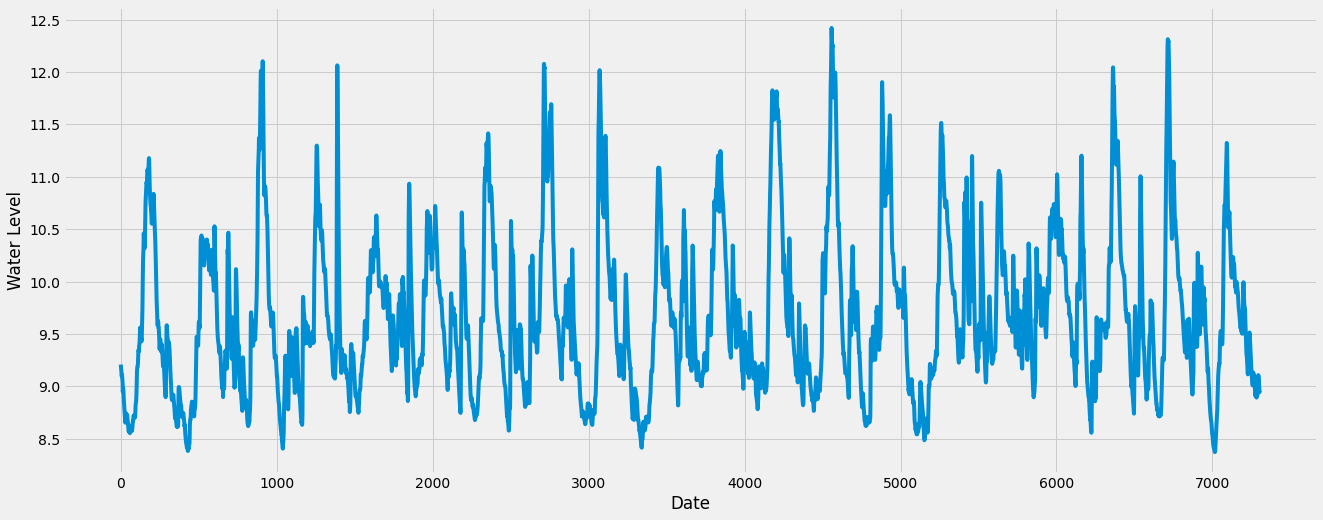

In [6]:
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.plot(example["Value"])
plt.show()

### Stationarity 

in the time series forecasting, we search usually for a stationary series. The series should have a constant mean, variance, and covariance.

so let's check if the  Water Level series is stationary or not. to do this i will use ADF (Augmented Dickey-Fuller) Test :

* Null Hypothesis: The series has a unit root
* Alternate Hypothesis: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary.

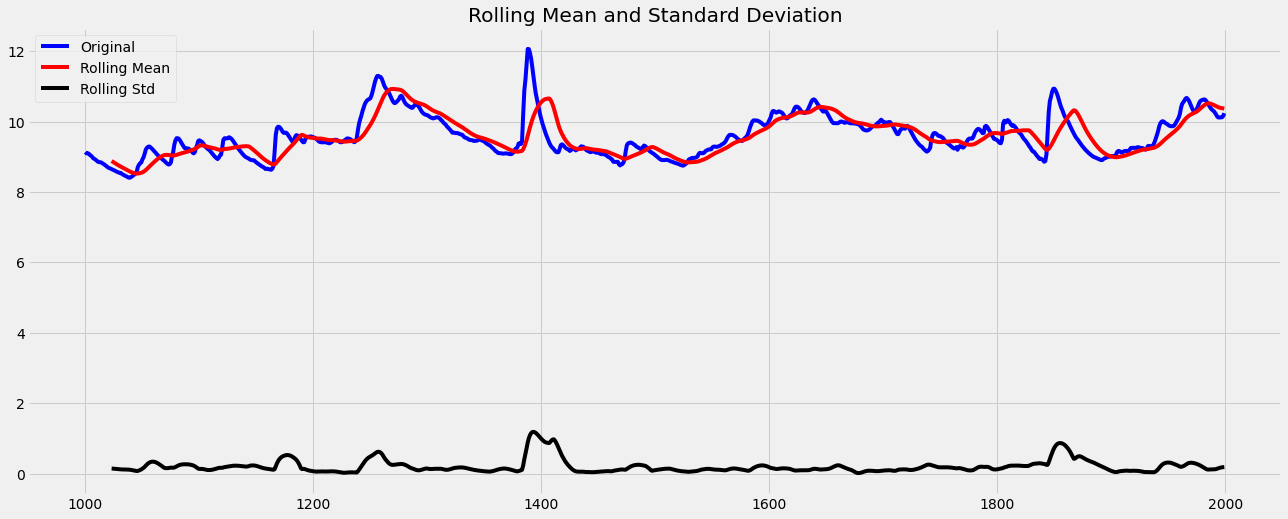

Results of dickey fuller test
Test Statistics                 -3.988307
p-value                          0.001473
No. of lags used                 5.000000
Number of observations used    994.000000
critical value (1%)             -3.436946
critical value (5%)             -2.864452
critical value (10%)            -2.568321
dtype: float64


In [7]:
test_stationarity(example["Value"].iloc[1000:2000])

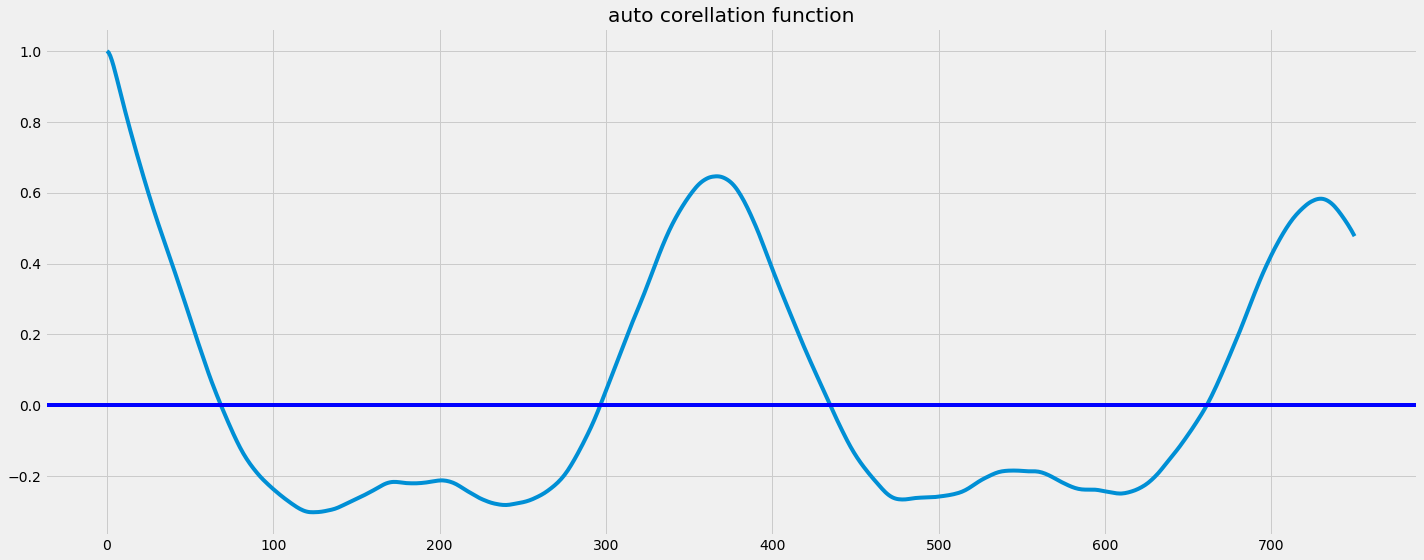

In [8]:
# we use d value here(data_log_shift)
_acf = acf(example['Value'], nlags=750)
#plot ACF
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('auto corellation function')
plt.tight_layout()

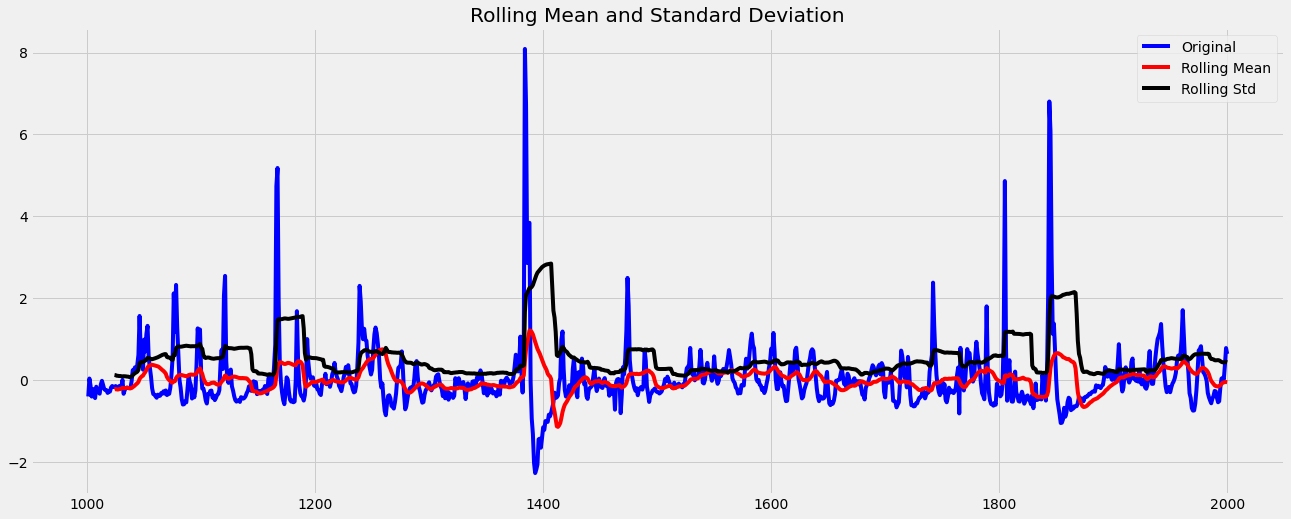

Results of dickey fuller test
Test Statistics               -1.209441e+01
p-value                        2.086623e-22
No. of lags used               4.000000e+00
Number of observations used    9.950000e+02
critical value (1%)           -3.436939e+00
critical value (5%)           -2.864449e+00
critical value (10%)          -2.568319e+00
dtype: float64


In [9]:
from numpy import inf
example['Water Level_previous'] = example["Value"].shift(1) 
example['WL_pct'] = 100*(example["Value"]  - example['Water Level_previous'] ) / example['Water Level_previous']
example.dropna(inplace = True)
example['WL_pct'] = example['WL_pct'].replace([+inf , - inf] , 0)
test_stationarity(example['WL_pct'].iloc[1000:2000])

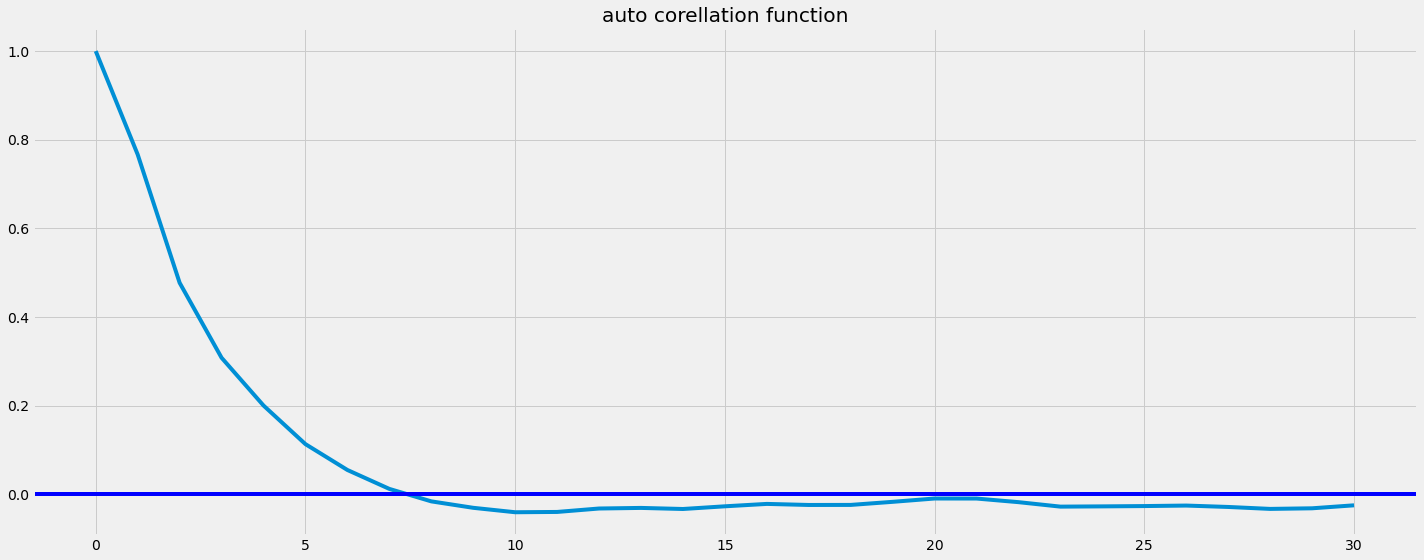

In [10]:
# we use d value here(data_log_shift)
_acf = acf(example['WL_pct'], nlags=30)
#plot ACF
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('auto corellation function')
plt.tight_layout()

### Target Distribution 

In [11]:
example.columns

Index(['Date', 'ID', 'PARAM', 'Value', 'Latitude', 'Longitude', 'Max Temp',
       'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days',
       'Total Precip', 'Water Level_previous', 'WL_pct'],
      dtype='object')

<AxesSubplot:>

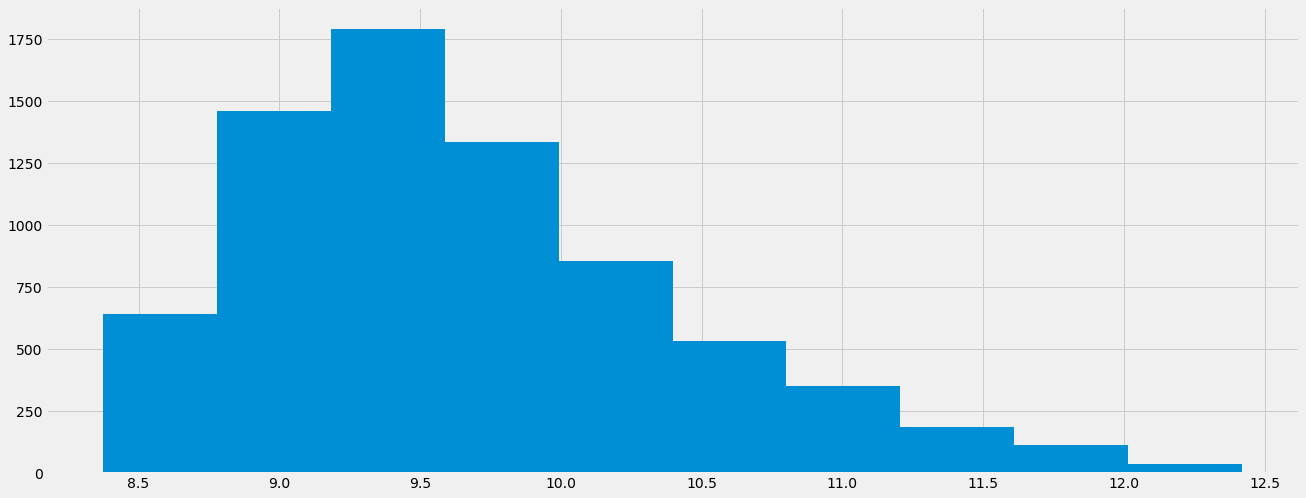

In [12]:
(example['Value']).hist()

# Multivariate time series analysis

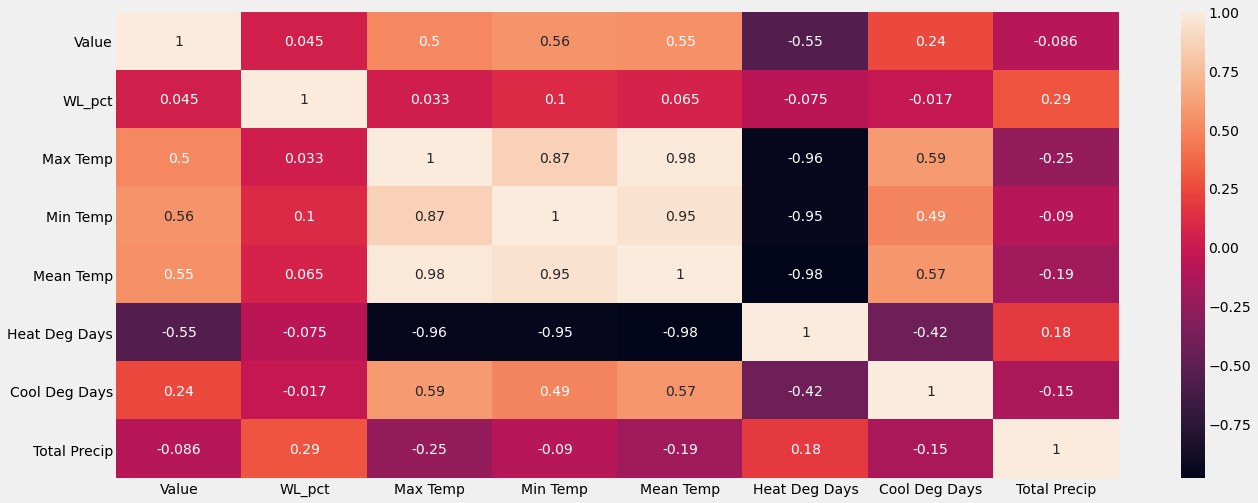

In [13]:
correlation_mat = example[['Value','WL_pct','Max Temp','Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days','Total Precip']].corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

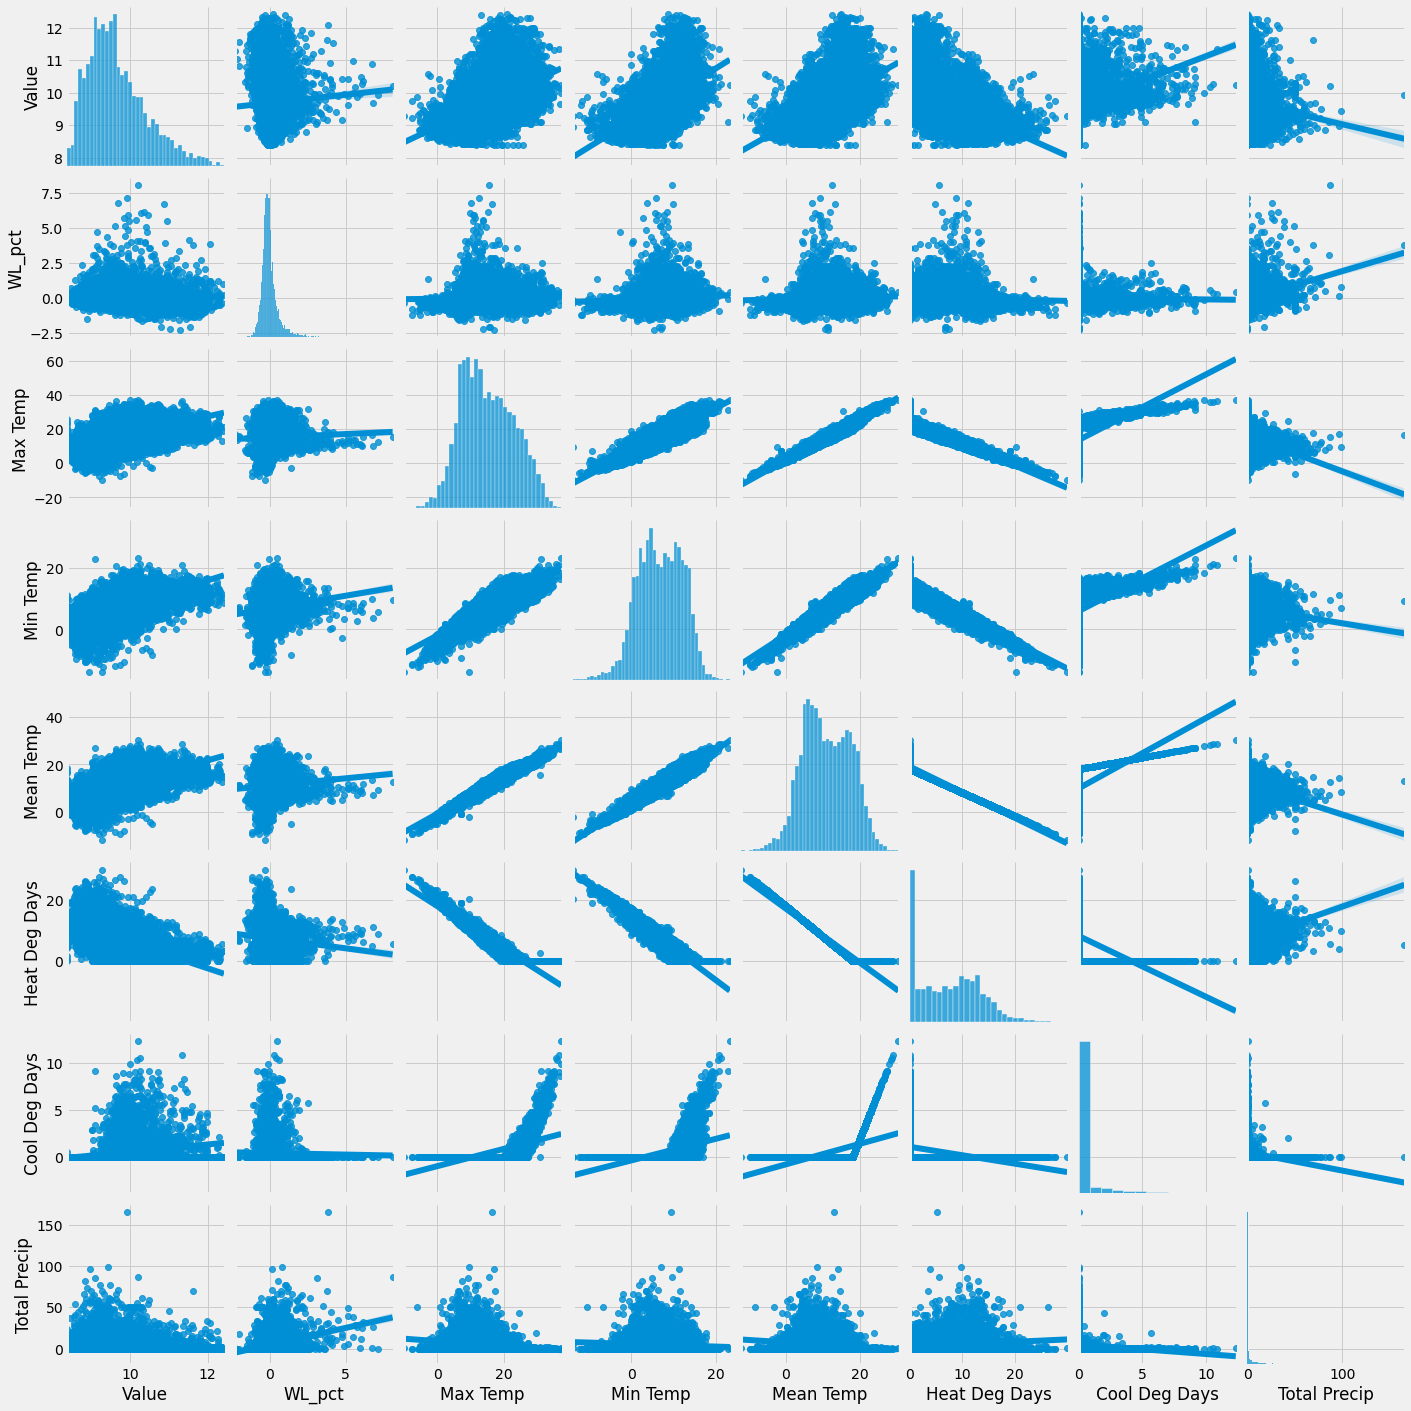

In [14]:
sns.pairplot(example[['Value','WL_pct','Max Temp','Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days','Total Precip']], kind='reg')


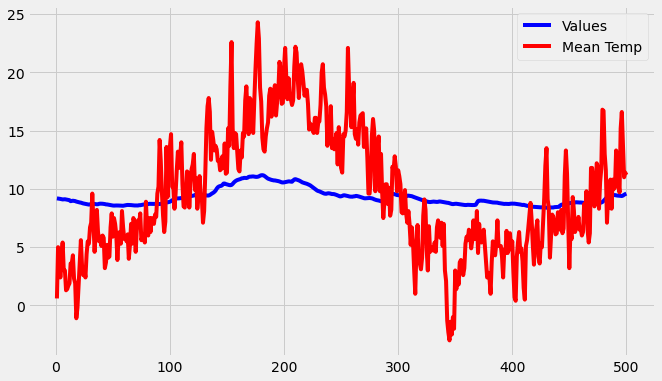

In [17]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(example['Value'].iloc[:500], color='blue', label = 'Values')
ax.plot(example['Mean Temp'].iloc[:500], color='red', label = 'Mean Temp')
plt.legend()
plt.show();

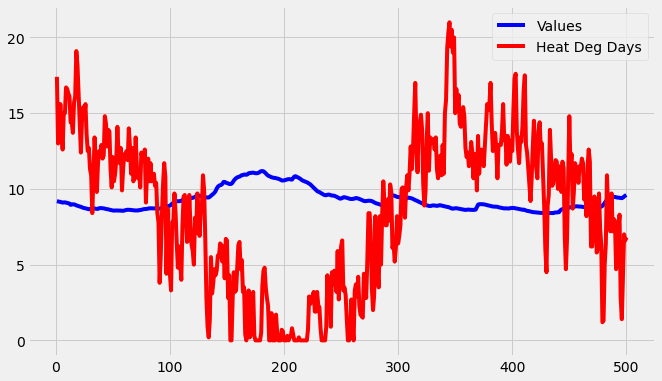

In [19]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(example['Value'].iloc[:500], color='blue', label = 'Values')
ax.plot(example['Heat Deg Days'].iloc[:500], color='red', label = 'Heat Deg Days')
plt.legend()
plt.show();

# Anomaly Detection based on LSTM AutoEncoders

The steps we will follow to detect anomalies in Hydrometric data using an LSTM autoencoder:
* Train an LSTM autoencoder on Hydrometric data from 2000–01–01 to 2016–01–01. We assume that there were no anomalies and they were normal.

* Using the LSTM autoencoder to reconstruct the error on the test data from 2016–01–01 to 2019-12-31.

* If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.

In [31]:
# Creating Helping Features 

example['WL_mean_7']  = example['WL_pct'].rolling(7).mean()
example['WL_mean_14'] = example['WL_pct'].rolling(14).mean()
example['WL_mean_30'] = example['WL_pct'].rolling(30).mean()

example['WL_std_7']   = example['WL_pct'].rolling(7).std()
example['WL_std_30']  = example['WL_pct'].rolling(30).std()

example['WL_lag_7']   = example['WL_pct'].shift(7)
example['WL_lag_14']  = example['WL_pct'].shift(30)
example['WL_lag_30'] = example['WL_pct'].shift(180)

num_feat = ['WL_pct','WL_mean_7','WL_mean_14','WL_mean_30','WL_std_7','WL_std_30','WL_lag_7','WL_lag_30']
example.dropna(inplace = True )


In [33]:
train = example[example.Date < '2017-01-01']
test  = example[example.Date  > '2017-01-01']

In [15]:
# Hyperparameters 
train_batch_size = 256
valid_batch_size = 128
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-3
device = torch.device('cuda')
window_size = 30  
path = 'auto_encoder.pth'
verbose = False

train_dataset = hydro_dataset(train , window_size , num_feat , is_auto_encoder= True )
valid_dataset = hydro_dataset(test , window_size , num_feat , is_auto_encoder= True)

model = AutoEncoder(input_size = len(num_feat) , hidden_size = 32 , emb_size = 16) 
model = model.to(device)
val_loss, train_loss = run(
    model,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose ,
    False
)

--------- Epoch 0 ---------
 train_loss  = 0.3312548001607259
 val_loss  = 0.34213027358055115
--------- Epoch 10 ---------
 train_loss  = 0.12598550723244747
 val_loss  = 0.3009089248047935
--------- Epoch 20 ---------
 train_loss  = 0.09095226787030697
 val_loss  = 0.26239679919348824
--------- Epoch 30 ---------
 train_loss  = 0.08057674051572879
 val_loss  = 0.2235848241382175
--------- Epoch 40 ---------
 train_loss  = 0.07454794148604076
 val_loss  = 0.2597251666916741
--------- Epoch 50 ---------
 train_loss  = 0.07122202590107918
 val_loss  = 0.07550727782977952
--------- Epoch 60 ---------
 train_loss  = 0.07153948117047548
 val_loss  = 0.0674321690781249
--------- Epoch 70 ---------
 train_loss  = 0.07053131734331448
 val_loss  = 0.0659853093740013
--------- Epoch 80 ---------
 train_loss  = 0.07186670880764723
 val_loss  = 0.06376885374387105
--------- Epoch 90 ---------
 train_loss  = 0.07022597795973222
 val_loss  = 0.06360572721395227


100%|██████████| 17/17 [00:00<00:00, 72.59it/s] 


<function matplotlib.pyplot.show>

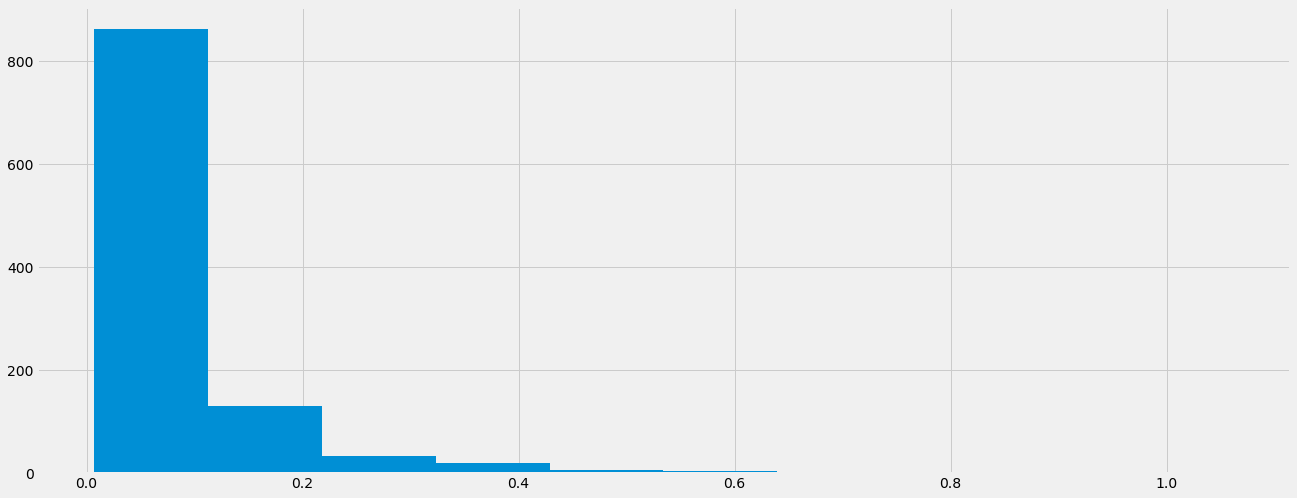

In [34]:
pred = predict_outliers(model,valid_dataset)
plt.hist(pred)
plt.show

In [35]:
thershold = 0.5
test = test.iloc[window_size:]
test['anomaly'] = pred > thershold

In [36]:
test['error'] = pred

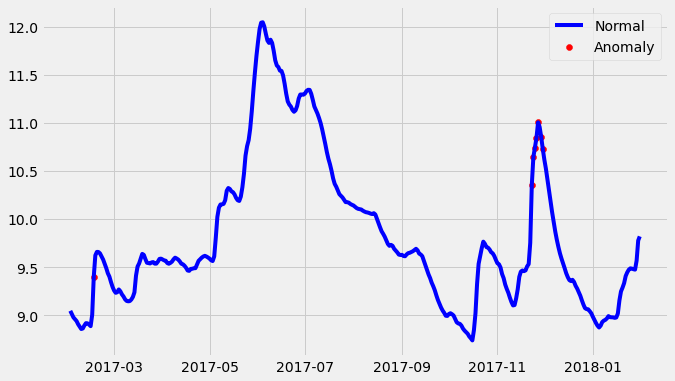

In [37]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))

test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date', inplace =True)

sub_set = test.iloc[:365]
a = sub_set.loc[sub_set['anomaly'] == 1, ['Value']] #anomaly

ax.plot(sub_set.index , sub_set['Value'], color='blue', label = 'Normal')
ax.scatter(a.index , a['Value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();